# Notebook to generate a practice dataset

## Wind Data

Let's use the pre-downloaded wind data from the Arabian Peninsula and create a dataframe of useful values

In [ ]:
import xarray as xr
import pandas as pd
import numpy as np
import os
import ee
import geemap
import cdsapi
import cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
file_path = '../raw_data/namib_desert_winds.nc'

ds = xr.open_dataset(file_path)
raw_data = ds.to_dataframe()
clean_df = raw_data.dropna().reset_index()
clean_df

### Adding wind strength feature

In [ ]:
clean_df['wind_strength'] = (clean_df.u10**2 + clean_df.v10**2)**.5
clean_df

### Adding Sin and Cosin of wind direction

In [ ]:
clean_df['sin'] = np.sin(np.arctan2(clean_df['u10'],clean_df['v10']))
clean_df['cosin'] = np.cos(np.arctan2(clean_df['u10'],clean_df['v10']))
clean_df

### Aggregating final wind dataset by mean()

In [ ]:
wind_data = clean_df.groupby(by=['latitude','longitude']).mean().reset_index()
wind_data

In [ ]:
def prep_data(path):
    ds = xr.open_dataset(path)
    raw_data = ds.to_dataframe()
    clean_df = raw_data.dropna().reset_index()
    clean_df['wind_strength'] = (clean_df.u10**2 + clean_df.v10**2)**.5
    clean_df['sin'] = np.sin(np.arctan2(clean_df['u10'],clean_df['v10']))
    clean_df['cosin'] = np.cos(np.arctan2(clean_df['u10'],clean_df['v10']))
    wind_data = clean_df.groupby(by=['latitude','longitude']).mean().reset_index()
    return wind_data

In [ ]:
def train_test_geographic_split(data:pd.DataFrame) -> pd.DataFrame:
    
    wind_data = data.copy()
    
    nb_long = wind_data.longitude.unique().shape[0]
    nb_lat = wind_data.latitude.unique().shape[0]

    nb_test_long = int(nb_long*.4)
    nb_test_lat = int(nb_lat*.4)

    test_lat = np.sort(wind_data.latitude.unique())[:nb_test_lat]
    test_long = np.sort(wind_data.longitude.unique())[:nb_test_long]

    wind_data.loc[:,'folder']='training'
    
    train_data = wind_data.copy()
    test_val_data = pd.DataFrame()

    for vlat in test_lat:
        for vlong in test_long:
            filter_ = ((train_data.latitude == vlat) & (train_data.longitude==vlong))
            test_val_data=pd.concat([test_val_data, train_data[filter_]])
            train_data =train_data[~filter_].copy()
            
    test_data, val_data = train_test_split(test_val_data, test_size=0.3)
    
    test_data.loc[:,'folder']='testing'
    val_data.loc[:,'folder']='validation'
    
    
    return pd.concat([train_data,test_data,val_data])

In [ ]:
path = '../raw_data/practice_wind_dataset.nc'

data = train_test_geographic_split(prep_data(path))

In [ ]:
data.folder.value_counts()

## Aquiring satellite images

### Base function 

In [ ]:
def get_image_per_coordinates(data:pd.Series, **kwargs) -> list:
    
        coordinates = [(data.longitude-0.025,data.latitude-0.025),
              (data.longitude-0.025,data.latitude+0.025),
              (data.longitude+0.025,data.latitude+0.025),
              (data.longitude+0.025,data.latitude-0.025)]
        
        for quadrant,coordinate in enumerate(coordinates):
            get_one_image(long=coordinate[0], lat=coordinate[1], data=data, quadrant=quadrant)
        
        return None

In [ ]:
def get_one_image(long:float, lat:float,data:pd.Series, quadrant:int, **kwargs) -> list:
    
    ee.Initialize()
    
    if 'resolution' in kwargs.keys():
        resolution=int(kwargs['resolution'])
    else:
        resolution = 512
    
    satellite_name='COPERNICUS/S2_SR'
    
    area = [(long-0.025,lat-0.025),
            (long+0.025,lat+0.025)]
        
    roi = ee.Geometry.Rectangle(coords=area)
           
    collection = ee.ImageCollection(satellite_name) \
                .filterBounds(roi) \
                .sort("CLOUD_COVER") \
                .filter('HIGH_PROBA_CLOUDS_PERCENTAGE < 10') \
                .limit(1)

    image = collection.first()
    
    vis_params = {
                  'bands': [ 'B4','B3','B2'],
                  'min': 0,
                  'max': 10000,
                  'gamma': 1.4}

    file_name = f"{lat}_{long}_0{quadrant}_CW000_{data.sin}_{data.cosin}_{data.wind_strength}"
    out_img = os.path.expanduser(f"../raw_data/practice_dataset/{file_name}.jpg")

    geemap.get_image_thumbnail(image, out_img,vis_params,dimensions=(resolution, resolution),region=roi, format='jpg')
        
    image_grey = cv2.imread(out_img)
    image_grey = cv2.cvtColor(image_grey, cv2.COLOR_BGR2GRAY)
    #plt.imshow(image_grey, cmap='Greys')
    cv2.imshow(file_name,image_grey)
    cv2.imwrite(f"../raw_data/practice_dataset/{file_name}.jpg",image_grey)
    #geemap.show_image(out_img)
    #images.append(out_img)
        
    return None

In [ ]:
file_path = '../raw_data/practice_wind_dataset.nc'
test_data = prep_data(file_path).iloc[1,:]
get_image_per_coordinates(test_data)

In [ ]:
file_path = '../raw_data/white_sands_winds.nc'
test_data = prep_data(file_path).iloc[1,:]
get_image_per_coordinates(test_data)

In [ ]:
file_path = '../raw_data/practice_wind_dataset.nc'
test_data = prep_data(file_path).iloc[0,:]
arabian_values = get_one_image(test_data)

In [ ]:
file_path = '../raw_data/namib_desert_winds.nc'
test_data = prep_data(file_path).iloc[0,:]
get_image_per_coordinates(test_data)

In [ ]:
test_data

In [ ]:
file_path = '../raw_data/gobi_winds.nc'
test_data = prep_data(file_path).iloc[0,:]
gobi_desert_values = get_one_image(test_data)

In [ ]:
resolutions = [128, 256,512, 1024,2048]

image_collection = []

for resolution in resolutions:
    print(f"RESOLUTION: {resolution} x {resolution} pixels")
    image_collection.append(get_one_image(test_data,resolution=resolution))

In [ ]:
def train_test_geographic_split(data:pd.DataFrame) -> pd.DataFrame:
    
    wind_data = data.copy()
    
    nb_long = wind_data.longitude.unique().shape[0]
    nb_lat = wind_data.latitude.unique().shape[0]

    nb_test_long = int(nb_long*.4)
    nb_test_lat = int(nb_lat*.4)

    test_lat = np.sort(wind_data.latitude.unique())[:nb_test_lat]
    test_long = np.sort(wind_data.longitude.unique())[:nb_test_long]

    wind_data['folder']='training'

    for vlat in test_lat:
        for vlong in test_long:
            wind_data.loc[(wind_data.latitude == vlat) & (wind_data.longitude==vlong),'folder']='testing'
            
    val = wind_data[wind_data.folder=='testing'].sample(frac=0.3)
    wind_data.loc[~val,'folder'] = 'validating'
    
    return wind_data

In [ ]:
df = prep_data('../raw_data/practice_wind_dataset.nc')
train_test_geographic_split(df)

In [ ]:
df2 = train_test_geographic_split(df)
df2

In [ ]:
df2.folder.unique()

In [ ]:
nb_long = wind_data.longitude.unique().shape[0]
nb_lat = wind_data.latitude.unique().shape[0]

nb_test_long = int(nb_long*.4)
nb_test_lat = int(nb_lat*.4)

test_lat = np.sort(wind_data.latitude.unique())[:nb_test_lat]
test_long = np.sort(wind_data.longitude.unique())[:nb_test_long]

test_validate_df = pd.DataFrame()

for vlat in test_lat:
    for vlong in test_long:
        test_validate_df = pd.concat([test_validate_df,wind_data[(wind_data.latitude == vlat) & (wind_data.longitude==vlong)]])


In [ ]:
test, validate = train_test_geographic_split(wind_data)

In [ ]:
validate

In [ ]:
white_sand_values

In [ ]:
feature = 'CLOUDY_PIXEL_PERCENTAGE'

print(white_sand_values['properties'][feature])
print(arabian_sand_values['properties'][feature])
print(namib_desert_values['properties'][feature])

In [ ]:
feature = 'HIGH_PROBA_CLOUDS_PERCENTAGE'

print(white_sand_values['properties'][feature])
print(arabian_sand_values['properties'][feature])
print(namib_desert_values['properties'][feature])

In [ ]:
'DARK_FEATURES_PERCENTAGE'
'SOLAR_IRRADIANCE_B9': 817.58,
'SOLAR_IRRADIANCE_B3': 1824.93,
    'SOLAR_IRRADIANCE_B12': 87.75,
  'SOLAR_IRRADIANCE_B10': 365.41,
  'SENSOR_QUALITY': 'PASSED',
  'SOLAR_IRRADIANCE_B11': 247.08,
  'GENERATION_TIME': 1544905108000,
  'SOLAR_IRRADIANCE_B8A': 953.93,
    'THIN_CIRRUS_PERCENTAGE': 25.026366,
        'SNOW_ICE_PERCENTAGE': 0.006193,
            'HIGH_PROBA_CLOUDS_PERCENTAGE': 16.185379,

In [ ]:
df = pd.read_csv('../raw_data/lists/dunes.csv')
df

In [ ]:
df.iloc[0,:].region

In [ ]:
'-25.208000564575194_15.001249694824219_04_CW000_-0.07344180345535278_0.8557981848716736_2.4399986267089844.jpg'
'-22.958000564575194_15.951750373840332_03_CW000_0.025373805314302444_-0.026895670220255852_1.3076690435409546'
'40.80500183105469_102.6050018310547_04_CW000_0.31416749954223633_0.4041779935359955_1.3764691352844238'
'-24.22500076293945_14.995000457763672_03_CW0'
'40.605001831054686_102.3550018310547_01_CW000_0.24751798808574677_0.2894478142261505_1.1759923696517944'

In [ ]:
'Fetching -24.425000762939455/15.295000457763672'
lat = 27.99900093078613
long = 24.292499923706053

ee.Initialize()
resolution = 512
    
area = [(long-0.025,lat-0.025),
            (long+0.025,lat+0.025)]
        
roi = ee.Geometry.Rectangle(coords=area)

    
vis_params = {'bands': [ 'B4','B3','B2'],
                  'min': 0,
                  'max': 10000,
                  'gamma': 1.4}
           
collection = ee.ImageCollection('COPERNICUS/S2_SR') \
                .filterBounds(roi) \
                .filter('HIGH_PROBA_CLOUDS_PERCENTAGE < 1') \
                .filter('NODATA_PIXEL_PERCENTAGE < 5') \
                .filter('DEGRADED_MSI_DATA_PERCENTAGE == 0') \
                .filter('SATURATED_DEFECTIVE_PIXEL_PERCENTAGE == 0') \
                .filter('DARK_FEATURES_PERCENTAGE < 5') \
                .limit(10)

image = collection.first()

out_img = os.path.expanduser(f"../raw_data/practice_dataset/test.jpg")

try:
    geemap.get_image_thumbnail(image, out_img,vis_params,dimensions=(resolution, resolution),region=roi, format='jpg')
except:
    print("Cannot fetch image from Sentinel, attempting to fet from Landsat")
    collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
                .filterBounds(roi) \
                .filter('CLOUD_COVER < 1') \
                .filter('CLOUD_COVER_LAND < 1') \
                .limit(10)
    image = collection.first()
    try:
        geemap.get_image_thumbnail(image, out_img,vis_params,dimensions=(resolution, resolution),region=roi, format='jpg')
    except:
        print("Cannot fetch image from either satellites (30 meters resolution)")

im = cv2.imread(out_img)

tot_pix = im.shape[0]*im.shape[1]*im.shape[2]
missing_pix = im[np.where(im == 0)].shape[0]

if missing_pix/tot_pix > 0.05:
    print("Too much information missing from picture, trying to fetch from Landsat 8")
    collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
                .filterBounds(roi) \
                .filter('CLOUD_COVER < 1') \
                .filter('CLOUD_COVER_LAND < 1') \
                .limit(10)
    image = collection.first()
    try:
        geemap.get_image_thumbnail(image, out_img,vis_params,dimensions=(resolution, resolution),region=roi, format='jpg')
    except:
        print("Cannot fetch image from Landstat 8")
geemap.show_image(out_img)
    


In [ ]:
file_ = '29.74900093078613_25.2427001953125_02_CW000_-0.03601320460438728_-0.6826015710830688_1.9123581647872925.jpg'
im = cv2.imread(f'../raw_data/images/training/dunes/{file_}')
tot_pix = im.shape[0]*im.shape[1]*im.shape[2]
missing_pix = im[np.where(im == 0)].shape[0]
missing_pix/tot_pix

In [ ]:
import datetime
datetime.datetime.now().strftime("%d-%b-%Y-%H:%M:%S.%f")

In [ ]:
d = {"time":[],
    "region":[],
    "image_latitude":[],
    "imge_longitude":[],
     "SENTINEL_available":[],
     "SENTINEL_complete":[],
     "LANDSAT_available":[],
     "LANDSAT_complete":[],
     "file_name":[]
    }
pd.DataFrame.from_dict(d)

In [ ]:
def train_test_geographic_split(data:pd.DataFrame) -> pd.DataFrame:
        wind_data = data.copy()
        nb_long = wind_data.longitude.unique().shape[0]
        nb_lat = wind_data.latitude.unique().shape[0]
        nb_test_long = 0
        nb_test_lat = 0
        
        while nb_test_long * nb_test_lat < wind_data.shape[0]*.3:
            nb_test_long += 1
            if (nb_test_long * nb_test_lat < wind_data.shape[0]*.3):
                nb_test_lat += 1
        

        test_lat = np.sort(wind_data.latitude.unique())[:nb_test_lat]
        test_long = np.sort(wind_data.longitude.unique())[:nb_test_long]
        wind_data.loc[:,'image_type']='dunes'
        wind_data.loc[:,'folder']='training'
        
        
        train_data = wind_data.copy()
        test_val_data = pd.DataFrame()

        for vlat in test_lat:
            for vlong in test_long:
                filter_ = ((train_data.latitude == vlat) & (train_data.longitude==vlong))
                test_val_data=pd.concat([test_val_data, train_data[filter_]])
                train_data =train_data[~filter_].copy()
        
        test_val_data.loc[:,'folder']='testing' 
        
        if (nb_test_long*nb_test_lat<3):
            print(f'Grid is too small to split: {nb_lat} x {nb_long}. Returning training and testing data only.')
            return pd.concat([train_data,test_val_data])
          
        test_data, val_data = train_test_split(test_val_data, test_size=0.3)   
        test_data.loc[:,'folder']='testing'
        val_data.loc[:,'folder']='validation'

        return pd.concat([train_data,test_data,val_data])

In [ ]:
fn = '../raw_data/wind/4.nc'
dat = prep_data(fn)
dat = train_test_geographic_split(dat)

In [ ]:
dat.folder.value_counts()

In [ ]:
112/(112+39+17)

In [ ]:
11/4

In [ ]:
data = pd.read_csv('../raw_data/lists/dunes.csv')
data

In [ ]:
data['lat_diff'] = (np.abs(data.north - data.south)/0.1).astype(int)
data['long_diff'] = (np.abs(data.west - data.east)/0.1).astype(int)
data['nb_cells']= data['lat_diff']*data['long_diff']
data

In [ ]:
nmp = 3
nb_photos = data.nb_cells.sum()*nmp**2
print(f'Total:{nb_photos}')
print(f'Train:{nb_photos*.6}')
print(f'Test:{nb_photos*.4*.7}')
print(f'Val:{nb_photos*.4*.3}')
print(f'Train_augmented:{nb_photos*.6*4} at a size of {.1/nmp*40000/360} km')

In [ ]:
px_res = (.1/nmp*40000/360*1000)/512
px_res

In [ ]:
pd.read_csv('../raw_data/logs/11-Jun-2021-11-16-28.csv')

In [ ]:

pd.DataFrame(columns=["time","image_latitude","image_longitude","SENTINEL_available",
              "SENTINEL_complete","LANDSAT_available",
              "LANDSAT_complete","file_name"]).to_csv('test.csv')

In [ ]:
pd.read_csv('test.csv')

In [ ]:
d = {"time":[datetime.datetime.now().strftime("%d-%b-%Y-%H:%M:%S.%f")],
            "image_latitude":[1],
            "image_longitude":[1],
            "SENTINEL_available":[1],
            "SENTINEL_complete":['no'],
            "LANDSAT_available":['no'],
            "LANDSAT_complete":['no'],
            "file_name":['no']
        }
pd.concat([pd.DataFrame.from_dict(d),
                               pd.read_csv('test.csv')])

In [ ]:
import cv2
import numpy as np
# from matplotlib import pyplot as plt

# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent=25):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)

    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))

    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 4.0

    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1

    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1

    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha

    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

In [ ]:
fn1='../raw_data/images/training/no_dunes/21.429000473022462_17.773750686645506_04_CW000_-0.8940587043762207_-0.0577491857111454_1.2933330535888672.jpg'

In [ ]:
os.path.exists(fn1)

In [ ]:
fn2 = '20.47900047302246_17.773750686645506_01_CW000_-0.7069132924079895_-0.2963283061981201_0.9895244240760803.jpg'

In [ ]:
folder = '../raw_data/images/training/no_dunes/'
path = f'{folder}{fn1}'
image = cv2.imread(path)
auto_result, alpha, beta = automatic_brightness_and_contrast(image)
print('alpha', alpha)
print('beta', beta)
cv2.imwrite(f'{folder}auto_result.png', auto_result)
#geemap.show_image(f'{folder}auto_result.png')

# Code to test the vertical flipping of an image

In [20]:
import cv2
import matplotlib.pyplot as plt
import math
from marswinds.utils import radian_to_degree, degree_to_radian, encode_angle, decode_angle
import numpy as np


image_name = '21.167500305175782_52.422499084472655_020_CW000_-0.5686831474304199_-0.4207611083984375_1.706290364265442.jpg'
folder_name = '../raw_data/practice_dataset'
path =f'{folder_name}/{image_name}'

In [15]:
def plot_image(folder_name='training',image_type='dunes', image_name=None, ax=None):
    
    if ax == None:
        fig, ax = plt.subplots(1,1,figsize=(4,4))
        
    folder_path = f'../images/{folder_name}/{image_type}'
    if image_name == None:
        image_name = random.choice(os.listdir(folder_path))
        path = f'{folder_path}/{image_name}'
    else:
        path = f'{folder_name}/{image_name}'
        
        
    data = image_name.split('_')
    wind_strength = float(data[-1].split('.')[0])
    original_sin = float(data[-3])
    original_cos = float(data[-2])
    original_angle = math.atan2(original_sin, original_cos)
    original_angle = radian_to_degree(original_angle)
    arrow_length = 64 
    if original_angle < 0: original_angle += 360
    
    if (original_angle<=90):
        arr_angle = degree_to_radian(original_angle)
        adj = np.cos(arr_angle)*arrow_length
        op = np.sin(arr_angle)*arrow_length
        dx = op*2
        dy = -adj*2
        tail_x = 128-op
        tail_y = adj+128
    if (original_angle<=180) & (original_angle>90):
        arr_angle = degree_to_radian(original_angle-90)
        adj = np.cos(arr_angle)*arrow_length
        op = np.sin(arr_angle)*arrow_length
        dx = adj*2
        dy = op*2
        tail_x = 128-adj
        tail_y = 128-op
    if (original_angle<=270) & (original_angle>180):
        arr_angle = degree_to_radian(original_angle-180)
        adj = np.cos(arr_angle)*arrow_length
        op = np.sin(arr_angle)*arrow_length
        dx = -op*2
        dy = adj*2
        tail_x = 128+op
        tail_y = 128-adj
    if (original_angle<=360) & (original_angle>270):
        arr_angle = degree_to_radian(original_angle-270)
        adj = np.cos(arr_angle)*arrow_length
        op = np.sin(arr_angle)*arrow_length
        dx = -adj*2
        dy = -op*2
        tail_x = 128+adj
        tail_y = 128+op
    print(path)
    img = cv2.imread(path)

    ax.imshow(img, cmap='Greys')
    ax.arrow(tail_x,tail_y,dx,dy,color='r',
         length_includes_head=True,
         width=wind_strength*5,
        alpha=.3)
    
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off
    
    return ax

../raw_data/practice_dataset/21.167500305175782_52.422499084472655_020_CW000_-0.5686831474304199_-0.4207611083984375_1.706290364265442.jpg


<AxesSubplot:>

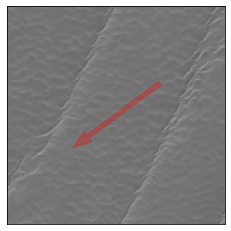

In [18]:
#im = cv2.imread(path)
plot_image(folder_name=folder_name,image_name=image_name)

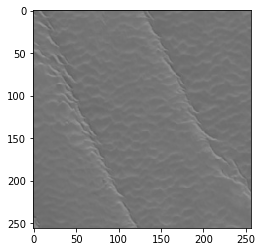

In [19]:
img = cv2.imread(path)
img_flip_lr = cv2.flip(img, 1)
plt.imshow(img_flip_lr, cmap='Greys')

In [25]:
original_angle = decode_angle(image_name)
original_angle

233.50275301557173

In [26]:
new_angle = 360-original_angle

In [27]:
new_angle

126.49724698442827

In [28]:
new_sin, new_cos = encode_angle(new_angle)
name_tags = image_name.split('_')
name_tags[-5] = f'{name_tags[-5]}F'
name_tags[-3] = str(new_sin)
name_tags[-2] = str(new_cos)
image_label = "_".join(name_tags)
image_path = f'{folder_name}/{image_label}'
cv2.imwrite(image_path,img_flip_lr)

True

../raw_data/practice_dataset/21.167500305175782_52.422499084472655_020F_CW000_0.8038854404400327_-0.5947841613968335_1.706290364265442.jpg


<AxesSubplot:>

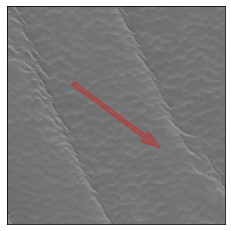

In [29]:
plot_image(folder_name=folder_name,image_name=image_label)